# 18.S096 pset 1, due midnight Monday, January 15.

The problem sets in 18.096 are of the form *we give you slow code, you give us faster code*.

In particular, you should write Julia functions `problem1(...)` and `problem2(...)` as described below, that implement your improved approach (but give the same results, up to floating-point roundoff errors).  You should submit (**via email** to the professors with the subject line *18.S096 pset 1*):

* A solutions file called `myusername.jl` which contains your function definitions (and any supporting code, e.g. other functions, `using` statements to import Julia packages, etcetera).   We will use these to (a) run your functions and check that the outputs are correct and (b) benchmark your performance.

* A *brief* discussion of what things you tried, what performance impact they had, and why you think particular changes made things faster/slower.   (You will be graded more the understanding demonstrated here than on how fast your code is.)   This can be in the form of text in the email, an attached IJulia notebook (`.ipynb`) file, or an attached PDF (printing notebooks to PDF is fine). 

As in class, you might find the BenchmarkTools package useful for timing.

## Problem 1

The following code implements the [transfer-matrix method from optics](https://en.wikipedia.org/wiki/Transfer-matrix_method_(optics)): it computes the optical [transmittance](https://en.wikipedia.org/wiki/Transmittance) through a [multilayer film](https://en.wikipedia.org/wiki/Optical_coating): a sequence of layers with thicknesses `L[i]` and [refractive indices](https://en.wikipedia.org/wiki/Refractive_index) `n[i]`.    It computes the transmittance T(λ) as a function of the optical [wavelength](https://en.wikipedia.org/wiki/Wavelength) λ.

You don't need to understand any of the physics here, though!   For each number λ, the code multiplies a bunch of $2\times 2$ matrices (one for each optical layer) together to get a matrix $M$, and then there is a formula to get the transmittance $T$ from the entries of the matrix $M$.

### Sample code:

Let's run it for a simple example of a [dielectric mirror](https://en.wikipedia.org/wiki/Dielectric_mirror) formed by alternating layers of high and low-index materials:

In [1]:
n = [1.2,1,1.4,1,1.6,1,1.8,1,2,1,2,1,2,1,1.9,1,1.8,1,1.6,1,1.5,1,1.3,1.1]
L = 1./n;

In [2]:
λ = linspace(0.7,2,1000)

tic()
T = zeros(length(λ))
for i = 1:length(λ)
    ω = 2π/λ[i]
    k = ω*n
    M = prod([[cos(k*L) sin(k*L)/k; -k*sin(k*L) cos(k*L)] for (k,L) in zip(k,L)])
    t = 2*im*ω / (-M[2,1] + ω^2 * M[1,2] + im*ω*(M[1,1]+M[2,2]))
    T[i] = abs2(t)
end
toc()

elapsed time: 0.633826064 seconds


0.633826064

The resulting transmittance exhibits a sequence of [stop bands](https://en.wikipedia.org/wiki/Stopband): wavelengths where the transmittance is almost zero (almost nothing gets through):

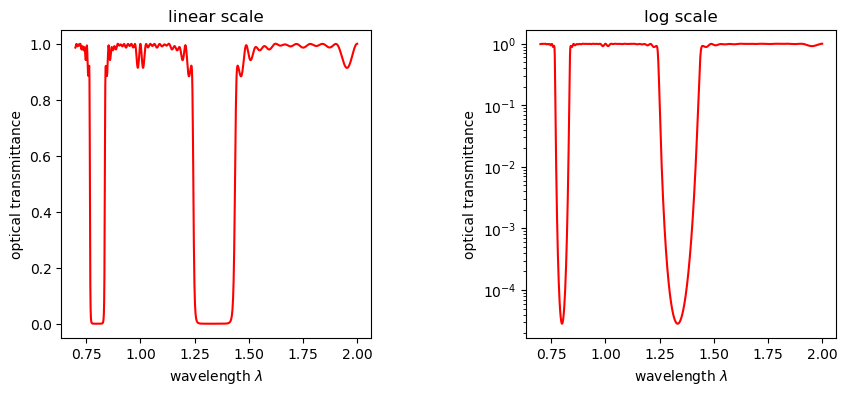

In [3]:
# Pkg.add("PyPlot") to install
using PyPlot

figure(figsize=(10,4))

subplot(1,2,1)
plot(λ, T, "r-")
xlabel(L"wavelength $\lambda$")
ylabel("optical transmittance")
title("linear scale")

subplot(1,2,2)
semilogy(λ, T, "r-")
xlabel(L"wavelength $\lambda$")
ylabel("optical transmittance")
title("log scale")

subplots_adjust(wspace=0.5)

### Assignment

First, **write a function**
```jl
function problem1(λ, n, L)
    ...
end
```
that takes three arguments:
* The wavelength `λ`.  A single number (of any type).
* The indices `n` of the layers: a 1d array of numbers (of any type).
* The thicknesses `L` of the layers: a 1d array of numbers (with `length(L) == length(n)`).
and returns the transmittance `T` as computed by the sample code above.

Initially, you'll just want to adapt this from the sample code above and **verify that it gives the same results**.  Then, **make it faster**:

* Consider different ways to multiply together a bunch of 2x2 matrices.  You don't have to use the `prod` function at all.  You don't have to form matrices at all — you can write things out by hand.  You might look at the impact of using the [StaticArrays package](https://github.com/JuliaArrays/StaticArrays.jl), which will unroll/optimized fixed-size matrix products for you.  There are also lots of little micro-optimizations you can try, e.g. the `sincos` function, using SIMD, etcetera.

You aren't allowed to use multiple processors, however — no parallelization.  (We will come back to that later in the course.)

## Problem 2

The code for this problem computes a [moving average](https://en.wikipedia.org/wiki/Moving_average) of some data.  Given an array `data` of the data, it averages each element with the `N-1` subsequent elements to create new "smoothed" data.   For a multidimensional array, it smooths along all of the directions.

(For a 1d array of length `n`, this would return a new array of length `n-N+1`, since we have to stop our moving average `N-1` elements before the end.)

To implement this generically for an arbitrary multidimensional array (1d, 2d, 3d, ...) is rather tricky, so for this problem we will only do the 2d case.

In [16]:
function problem2(data::AbstractMatrix, N)
    m, n = size(data)
    1 ≤ N ≤ min(m,n) || throw(ArgumentError("invalid N=$N"))
    return [mean(data[i:i+N-1,j:j+N-1]) for i = 1:m-N+1, j = 1:n-N+1]
end

problem2 (generic function with 1 method)

The code should, of course, work on an array of floating-point numbers:

In [11]:
a = [1.0 2.0 3.0] .+ [0.0, 1.0, 1.0]

3×3 Array{Float64,2}:
 1.0  2.0  3.0
 2.0  3.0  4.0
 2.0  3.0  4.0

In [12]:
problem2(a, 2)

2×2 Array{Float64,2}:
 2.0  3.0
 2.5  3.5

In [13]:
problem2(a, 3)

1×1 Array{Float64,2}:
 2.66667

In [14]:
mean(a)

2.6666666666666665

But it should also work on arrays of other quantities, e.g. images can be described as arrays of colors:

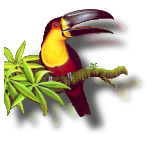

In [6]:
#Pkg.add("Images")
#Pkg.add("TestImages")
using Images, TestImages
img = testimage("toucan")

In [15]:
typeof(img)

Array{ColorTypes.RGBA{FixedPointNumbers.Normed{UInt8,8}},2}

A moving average of an image creates a blurred image (technically a [box blur](https://en.wikipedia.org/wiki/Box_blur)):

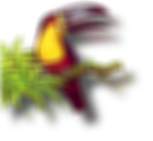

In [9]:
problem2(img, 10)

### Assignment:

Make the `problem2` function faster (for various array sizes and values of `N`).  (But it should still produce the same results, and still work for arrays of different types as in the examples above.)

Some possibilities to keep in mind:

* Be aware of the difference between [slices and views in Julia](https://docs.julialang.org/en/stable/manual/performance-tips/#Consider-using-views-for-slices-1).
* You can experiment with different ways of writing out the loops, and different loop orders.
* Consider the difference between the moving average for two adjacent pixels; is there a way to share some of the computational work rather than re-doing the average from scratch each time?